In [28]:
import scipy
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# pyqubo imports
from pyqubo import Binary, Array
from pprint import pprint
from dimod import ExactSolver

#myqlm imports
from qat.qpus import get_default_qpu
from qat.core import Observable, Term
#import import_ipynb
#import ipynb

import networkx as nx
import matplotlib.pyplot as plt

from QAOAutils import SolverQAOA

# Problema do K-Clique

O Problema do K-Clique consiste em encontrar um subgrafo completo, $\hat{G}$, composto por $K$ vértices (nós), em um dado grafo $G(V,E)$. Um grafo é completo quando todos os seus vértices nós interconectados. Na figura abaixo, podemos ver um grafo e seu respectivo clique de tamanho $K=4$.

<img src="grafo_clique.png" width=750 />



É possível verificar que o conjunto dos vértices $|V_c| = \{0,1,2,3\} $ formam um clique de tamanho $K=4$, pois formam um grafo completo. 

### Exercício 1:

Vamos codificar o grafo da figura anterior e desenhá-lo usando a framework `Networkx`.
Substitua a resposta correta pelos 2 FIXMEs no código abaixo.

In [22]:
#Criando um grafo G
# crie uma estrutura que codifique o grafo
G = nx.Graph()

# crie uma lista com os indices de cada nó
nodes = [i for i in range(5)]

# crie uma lista de tuplas com os nos vizinhos: g=[..., (ni,nj),...]
g = [(0,1),(0,2),(0,3),(1,2),(1,3),(2,3),(2,4),(3,4)]

G.add_edges_from(g)
#nx.draw(G, with_labels=True)
print(G)

Graph with 5 nodes and 8 edges


### Exercício 2:

Agora, defina os parâmetros do problema. Note que queremos encontrar um clique de tamanho $K=4$ no grafo dado como exemplo.
Substitua a resposta correta pelos 4 FIXMEs no código abaixo.

In [23]:
# -----------------
# parametros do problema
# -----------------

# defina o tamanho do clique
K= 4
# numero de nos do grafo
num_nodes = len(nodes)
# numero de arestas no clique
E = K*(K-1)//2
# penalidades para Ha e Hb
A,B = 4,1

print(f"Tamanho do Clique: {K}\n Número de nós: {num_nodes}\n Número de arestas no Clique: {E}\n Constantes de penalidade: {A} e {B}.")


Tamanho do Clique: 4
 Número de nós: 5
 Número de arestas no Clique: 6
 Constantes de penalidade: 4 e 1.


## Formulação como Otimização Irrestrita

Formularemos o problema como uma função de otimização com variáveis binárias, $x_i \in \{0,1\}$, sendo que o "estado" de cada vértice é dado por $x_i$. Se $x_i = 1$, indica que o vértice de índice $i$ faz parte do clique. A solução do exemplo com o grafo apresentado anteriormente é dada por $\vec{x} = 11110$, visto que apenas o vértice $4$ não faz parte do clique.

Apresentaremos dois termos de penalidades necessários para escrever o Problema do Clique como Otimização Irrestrita. Um dos termos está relacionado ao fato de que o número de vértices no estado $x_i = 1$ deve ser igual a $K$. Para isso, criamos o termo

$$ H_a = \left(K - \sum_{i=0}^{N}x_i\right)^2. $$

Quanto maior a diferença entre $K$ e o número de vértices em estado $1$, maior será a penalidade na função objetivo. O valor de $H_a$ será $0$ (mínimo) quando o critério for atendido. 

### Exercício 3a:

Escreva o termo $H_a$ da função objetivo em termos das variáveis binárias `Binary('xi')` do Pyqubo.

In [30]:
# ----------------------------------------
# criando as variaveis binarias com pyqubo
# ----------------------------------------

# criando o termo Ha
variables = Array.create('x', shape=num_nodes, vartype='BINARY')
x_sum = sum(variables) 

Ha = (K - x_sum)**2
Ha

((4.000000 + (-1.000000 * (Binary('x[4]') + Binary('x[3]') + Binary('x[2]') + Binary('x[1]') + 0.000000 + Binary('x[0]')))) * (4.000000 + (-1.000000 * (Binary('x[4]') + Binary('x[3]') + Binary('x[2]') + Binary('x[1]') + 0.000000 + Binary('x[0]')))))

Contudo, claramente, essa condição não é suficiente para garantir que o clique seja encontrado. Para isso, introduziremos outros conceitos, começando pela quantidade de arestas em um clique. Essa quantidade é dada por

$$E = \frac{K(K-1)}{2}.$$

Logo, introduziremos um novo termo na função objetivo, cujo papel desempenhado é o de penalizar a função caso o número de arestas do subgrafo que conectam os nós de estado $x_i = 1$ seja diferente de $E$. Queremos que a quantidade de arestas do clique seja igual a $E$, logo, criamos o seguinte termo:

$$H_b = E - \sum_{<ij>}x_ix_j$$
onde $<ij>$ representa os índices apenas dos vértices conectados entre si. 

### Exercício 3b:

Escreva o termo $H_b$ da função objetivo em termos das variáveis binárias `Binary('xi')` do Pyqubo.

In [32]:
# criando o termo Hb
quadratic_terms_sum = sum([variables[edge[0]]*variables[edge[1]] for edge in g])

Hb = E - quadratic_terms_sum
Hb

(6.000000 + (-1.000000 * ((Binary('x[3]') * Binary('x[4]')) + (Binary('x[2]') * Binary('x[4]')) + (Binary('x[2]') * Binary('x[3]')) + (Binary('x[1]') * Binary('x[3]')) + (Binary('x[1]') * Binary('x[2]')) + (Binary('x[0]') * Binary('x[3]')) + (Binary('x[0]') * Binary('x[2]')) + 0.000000 + (Binary('x[0]') * Binary('x[1]')))))

Introduziremos ainda as variáveis de penalidade dadas por $A$ e $B$, que são números inteiros usados para controlar a função objetivo e garantir que as restrições serão atendidas. Sendo assim, a função objetivo final é dada por 

$$H = A\left(K - \sum_{i=0}^{N}x_i\right)^2 + B\left( C - \sum_{<ij>}x_ix_j\right).$$

Neste problema, devemos considerar as constantes de penalidade satisfaznedo $A > B$.

### Exercício 3c:

Escreva a função objetivo inteira juntando os termos $H_a$ e $H_b$ com suas variáveis de penalidade.

In [33]:
# escreva a função objetivo
H = A*Ha + B*Hb

model = H.compile()
qubo = model.to_qubo()
print(qubo)

({('x[4]', 'x[0]'): 8.0, ('x[0]', 'x[0]'): -28.0, ('x[3]', 'x[1]'): 7.0, ('x[3]', 'x[0]'): 7.0, ('x[4]', 'x[4]'): -28.0, ('x[4]', 'x[2]'): 7.0, ('x[4]', 'x[1]'): 8.0, ('x[4]', 'x[3]'): 7.0, ('x[3]', 'x[2]'): 7.0, ('x[3]', 'x[3]'): -28.0, ('x[2]', 'x[2]'): -28.0, ('x[1]', 'x[1]'): -28.0, ('x[2]', 'x[1]'): 7.0, ('x[1]', 'x[0]'): 7.0, ('x[2]', 'x[0]'): 7.0}, 70.0)


In [34]:
single_values = {}
multiple_values = {}
for k,v in qubo[0].items():
    if k[0] == k[1]:
        single_values[int(k[0][2])] = v
    else:
        multiple_values[(int(k[0][2]), int(k[1][2]))] = v

num_qubits = num_nodes
hamiltonian_clique = Observable(num_qubits,
                           pauli_terms=
                           [Term(single_values[x], "Z", [x]) for x in single_values]+
                           [Term(multiple_values[x], "ZZ", [x[0],x[1]]) for x in multiple_values],
                           constant_coeff=qubo[1]
                           )

print(hamiltonian_clique)

70.0 * I^5 +
-28.0 * (Z|[0]) +
-28.0 * (Z|[4]) +
-28.0 * (Z|[3]) +
-28.0 * (Z|[2]) +
-28.0 * (Z|[1]) +
8.0 * (ZZ|[4, 0]) +
7.0 * (ZZ|[3, 1]) +
7.0 * (ZZ|[3, 0]) +
7.0 * (ZZ|[4, 2]) +
8.0 * (ZZ|[4, 1]) +
7.0 * (ZZ|[4, 3]) +
7.0 * (ZZ|[3, 2]) +
7.0 * (ZZ|[2, 1]) +
7.0 * (ZZ|[1, 0]) +
7.0 * (ZZ|[2, 0])


## Resolução de um problema de otimização irrestrita com um circuito variacional quântico

## Circuito QAOA

<p align="center">
<img src="qaoa_cirq.png" width="800" />
</p>

### Exercício 4:

Crie o objeto `qaoa`, através da classe SolverQAOA, com seus argumentos declarados corretamente.
Substitua a resposta correta pelos 4 FIXMEs no código abaixo.

In [5]:
qaoa = SolverQAOA(binary_model = model, num_variables = 5, num_measurements = 1000, depth=4)

### Exercício 5:

Crie o circuito para operador de fase do QAOA e atribua um parametro qualquer no intervalo [0, pi].
Substitua a resposta correta pelo FIXME no código abaixo.

In [6]:
phase_circuit = qaoa.phase_op(gamma = np.pi)
%qatdisplay phase_circuit --svg

### Exercício 6:

Crie o circuito para operador mixer do QAOA e atribua um parametro qualquer no intervalo [0, pi].
Substitua a resposta correta pelo FIXME no código abaixo.

In [7]:
mix_circuit = qaoa.mixer_op(np.pi)
%qatdisplay mix_circuit --svg

### Exercício 7:

Defina um chute inicial para os parametros variacionais de todo o circuito, baseado na profundidade do circuito `depth`. Através do método `full_circuit_measurements`, crie o circuito completo e as `num_measurements` medidas para o chute incicial.
Substitua a resposta correta pelos 2 FIXMEs no código abaixo.

In [8]:
# camada única do QAOA e medidas para chute inicial de gamma e beta
initial_guess = np.random.uniform(0,np.pi,8)
full_circ, initial_meas = qaoa.full_circuit_measurements(initial_guess)
%qatdisplay full_circ --svg

/home/omp/anaconda3/envs/QML/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<BarContainer object of 28 artists>

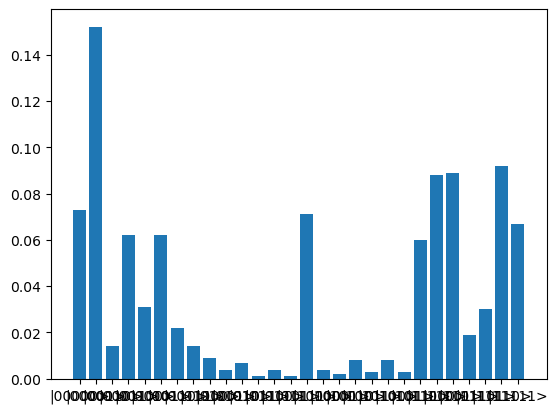

In [9]:
states=[]; probs = []
for key, value in initial_meas.items():
    states.append(str(key))
    probs.append(value)

plt.bar(states, probs)

In [10]:
print(states)
print(probs)

['|00000>', '|00001>', '|00010>', '|00011>', '|00100>', '|00101>', '|00110>', '|00111>', '|01000>', '|01001>', '|01010>', '|01011>', '|01100>', '|01101>', '|01111>', '|10000>', '|10001>', '|10010>', '|10011>', '|10100>', '|10101>', '|10111>', '|11000>', '|11001>', '|11011>', '|11101>', '|11110>', '|11111>']
[0.073, 0.152, 0.014, 0.062, 0.031, 0.062, 0.022, 0.014, 0.009, 0.004, 0.007, 0.001, 0.004, 0.001, 0.071, 0.004, 0.002, 0.008, 0.003, 0.008, 0.003, 0.06, 0.088, 0.089, 0.019, 0.03, 0.092, 0.067]


### Exercício 8:

Através do método `cost_function`, calcule as funções custo individuais para as soluções '00001' e '11100'. Interprete os resultados. Supondo que tenhamos realizado 10 medidas no circuito quântico e os autoestados medidos fossem justamente '00001' 2 vezes e '11100' 8 vezes, qual seria a estimativa para o valor esperado nesse caso?
Substitua a resposta correta pelo FIXME no código abaixo.

In [11]:
# cada energia relacionada a um autoestado
# exemplo:
energy_00001 = qaoa.cost_function('00001')

energy_11100 = qaoa.cost_function('11100')

print("Energia associada ao autoestado |11100>:  ", energy_11100, "\n",70*"#")
print("Energia associada ao autoestado |00001>:  ", energy_00001, "\n",70*"#")

exp_value_00001_11100 =  (energy_00001*2 + energy_11100*8)/10

print("Valor esperado das 10 medidas hipoteticas:  ", exp_value_00001_11100, "\n",70*"#")

Energia associada ao autoestado |11100>:   -63.0 
 ######################################################################
Energia associada ao autoestado |00001>:   -28.0 
 ######################################################################
Valor esperado das 10 medidas hipoteticas:   -56.0 
 ######################################################################


### Exercício 9:

Através do método `expected_value`, calcule o valor esperado para o número de medidas `num_measurements` que voce escolheu. Note que o argumento do método é o `initial_guess`.
Substitua a resposta correta pelo FIXME no código abaixo.

In [12]:
# valor esperado de energia <psi|H|psi> para os chutes iniciais:
exp_val = qaoa.expected_value(initial_guess)
print(" \n \n Valor esperado de energia para o chute inicial:  ", exp_val, "\n",70*"#")

 
 
 Valor esperado de energia para o chute inicial:   -49.13099999999999 
 ######################################################################


In [13]:
# Rodando o algoritmo com o método run()
res = qaoa.run()

 	 Expected value from measurements:  -53.904  	 Variational parameters:  [2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 	 Expected value from measurements:  -57.78099999999999  	 Variational parameters:  [1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 	 Expected value from measurements:  -40.48600000000001  	 Variational parameters:  [1. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 	 Expected value from measurements: 

/home/omp/anaconda3/envs/QML/lib/python3.9/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: ftol, iprint, eps, finite_diff_rel_step
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


 -48.26700000000001  	 Variational parameters:  [1. 2. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 	 Expected value from measurements:  -52.91899999999999  	 Variational parameters:  [1. 2. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 	 Expected value from measurements:  -44.221999999999994  	 Variational parameters:  [1. 2. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 	 Expected value from measurements:  -50.45400000000001  	 Variational parameters:  [1. 2. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 	 Expected value from measurements:  -50.38699999999999  	 Variational parameters:  [1. 2. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 	 Expected value from measurements:  -57.80199999999999  	 Variational parameters:  [1. 2. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 	 Expected value from measurements:  -57.80199999999999  	 Variational parameters:  [1. 2. 1. 1. 1. 1. 1. 1. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 	 Expe

### Exercício 10:

Repita o experimento algumas vezes para $K=3$. Comente os resultados.